In [1]:
from pyspark.sql import SparkSession

#
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("FrequentItemsets") \
    .config("spark.master", "local") \
    .config("spark.jars", "F:/UniPrj/Big Data Project/postgresql-42.2.16.jar") \
    .getOrCreate()


In [2]:
jdbc_url = "jdbc:postgresql://localhost:5432/AmazonProducts"
properties = {
    "user": "postgres",
    "password": "root",
    "driver": "org.postgresql.Driver"
}

data_df = spark.read.jdbc(url=jdbc_url, table="music_fpgrowth", properties=properties)
data_df.show()
print((data_df.count(), len(data_df.columns)))

+-----------+--------------+----------+--------------------+
|customer_id|     review_id|product_id|       product_title|
+-----------+--------------+----------+--------------------+
|   10140119|R3LI5TRP3YIDQL|B00TXH4OLC|Whatever's for Us...|
|   27664622|R3LGC3EKEG84PX|B00B6QXN6U|Same Trailer Diff...|
|   45946560| R9PYL3OYH55QY|B001GCZXW6| Soaring (Jazz Club)|
|   15146326|R3PWBAWUS4NT0Q|B000003EK6|     CARIBBEAN PARTY|
|   16794688|R15LYP3O51UU9E|B00N1F0BKK|         Pain Killer|
|   32203364|R1AD7L0CC3DSRI|B00V7KAO7Q|A Thoughtiverse U...|
|    1194276|R32FE8Y45QV434|B000094Q4P|Comfort of Her Wings|
|   45813052|R3NM4MZ4XWL43Q|B00JMK0P1I|Sleep Soundly CD ...|
|   12795687|R3H4FXX6Q7I37D|B008OW1S3O|     An Awesome Wave|
|   36673840|R30L5PET7LFFDC|B00VI2L3L4|          Blurryface|
|   49453576|  REFRE1LEKLAF|B0000041EV|Mozart For Mother...|
|    3285047|R3JTJ5EQN74E9H|B00005YW4H|   Come Away with Me|
|   24471201|R1W2F091LCOAW5|B00Q9KEZV0| Tomorrow Is My Turn|
|   28049396| RYUMFQRRB1

In [3]:
from pyspark.sql.functions import collect_list, collect_set

# Remove duplicate product IDs within each transaction
baskets_df = data_df.groupBy("customer_id").agg(
    collect_set("product_id").alias("frequent_product_sets"))

baskets_df.show()

+-----------+---------------------+
|customer_id|frequent_product_sets|
+-----------+---------------------+
|      10099| [B00COCY67A, B00F...|
|      10185| [B003P8P1TO, B000...|
|      10235|         [B002DORHVG]|
|      10293| [B00KYTY81E, B008...|
|      10327|         [B000002SJM]|
|      10358|         [B000OHXD08]|
|      10378| [B006XBSAP2, B008...|
|      10626|         [B0042GNDO8]|
|      10672|         [B0000029DD]|
|      10807| [B000050XEI, B002...|
|      10970| [B00000AG8K, B000...|
|      10983|         [B00RPUPYHC]|
|      11127|         [B00OQMHVJG]|
|      11263| [B00006BINS, B002...|
|      11348|         [B000P1YM2G]|
|      11405|         [B002MOWA9G]|
|      11573|         [B00QHDL6PW]|
|      11611|         [B008PDAFZO]|
|      11790| [B00UDDM7K0, B000...|
|      11861|         [B00TH87L8U]|
+-----------+---------------------+
only showing top 20 rows



In [4]:
from pyspark.ml.fpm import FPGrowth

fp_growth = FPGrowth(itemsCol="frequent_product_sets", minSupport=0.0001, minConfidence=0.5)
model = fp_growth.fit(baskets_df)


In [5]:
frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

+------------+----+
|       items|freq|
+------------+----+
|[B00EZ8GADY]| 343|
|[B002Q5O6PC]| 135|
|[B001TW68P4]| 114|
|[B0089PZCAQ]| 179|
|[B00006RAKP]| 339|
|[B000R7I3LY]| 138|
|[B00G34XP3Q]| 177|
|[B0019FOC5E]| 280|
|[B0001GOH98]| 175|
|[B003019LWO]| 275|
|[B005V3XCMO]|  91|
|[B002PMMQ1W]| 148|
|[B00B2TE7FC]| 119|
|[B00K3CF9GA]| 146|
|[B00NQKWA6S]| 408|
|[B003KUSUG8]| 200|
|[B003OUXEMY]|  99|
|[B002FWYL5G]| 115|
|[B0000E1WKE]| 140|
|[B009A9ELTS]| 100|
+------------+----+
only showing top 20 rows



In [6]:
from mlxtend.frequent_patterns import association_rules
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


# Assuming 'frequent_item_sets' is a PySpark DataFrame, convert it to a pandas DataFrame
frequent_itemsets_df = frequent_itemsets.toPandas()

frequent_itemsets_df

,items,freq
0,[B00EZ8GADY],343
1,[B002Q5O6PC],135
2,[B001TW68P4],114
3,[B0089PZCAQ],179
4,[B00006RAKP],339
...,...,...
1835,[B00BPWDMP2],242
1836,[B00BNR6RJW],252
1837,[B0000CDL6V],90
1838,[B00DN713KI],103


In [7]:


# Convert the item sets to a binary format (1 for present, 0 for absent)
frequent_itemsets_df['itemsets'] = frequent_itemsets_df['items'].apply(lambda x: set(x))
frequent_itemsets_df['support'] = frequent_itemsets_df['freq'] / frequent_itemsets_df.shape[0]

# Select only the 'itemsets' and 'support' columns
frequent_itemsets_df = frequent_itemsets_df[['itemsets', 'support']]
frequent_itemsets_df


,itemsets,support
0,{B00EZ8GADY},0.186413
1,{B002Q5O6PC},0.073370
2,{B001TW68P4},0.061957
3,{B0089PZCAQ},0.097283
4,{B00006RAKP},0.184239
...,...,...
1835,{B00BPWDMP2},0.131522
1836,{B00BNR6RJW},0.136957
1837,{B0000CDL6V},0.048913
1838,{B00DN713KI},0.055978


In [8]:
min_confident=0.5
rules = association_rules(frequent_itemsets_df, metric="confidence", min_threshold=min_confident)
print(rules)

                antecedents   consequents  antecedent support  \
0              (B00IXHBZF6)  (B00IXHBL7I)            0.112500   
1              (B00IXHBZF6)  (B00IXHBS6M)            0.112500   
2              (B00IXHBS6M)  (B00IXHBZF6)            0.119022   
3  (B00IXHBL7I, B00IXHBZF6)  (B00IXHBS6M)            0.059783   
4  (B00IXHBL7I, B00IXHBS6M)  (B00IXHBZF6)            0.061957   
5  (B00IXHBZF6, B00IXHBS6M)  (B00IXHBL7I)            0.061413   
6              (B001TCHDPS)  (B001BKVWYG)            0.295109   
7              (B00KR6332Y)  (B00NEJ7MMI)            0.251630   
8              (B00IXHBL7I)  (B00IXHBS6M)            0.121196   
9              (B00IXHBS6M)  (B00IXHBL7I)            0.119022   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.121196  0.059783    0.531401  4.384654  0.046148    1.875387   
1            0.119022  0.061413    0.545894  4.586504  0.048023    1.940027   
2            0.112500  0.061413    0.515982  4.

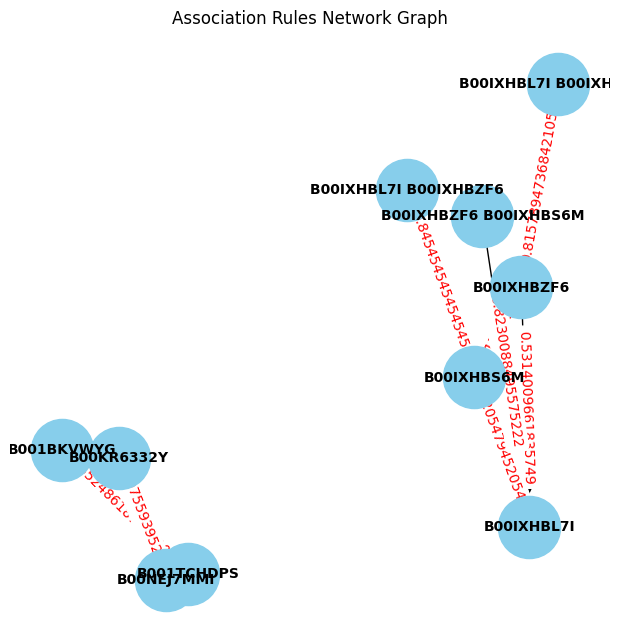

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes for antecedents and consequents
for index, row in rules.iterrows():
    antecedent = " ".join(row['antecedents'])  # Replace 'antecedent_column_name'
    consequent = " ".join(row['consequents'])  # Replace 'consequent_column_name'
    G.add_node(antecedent)
    G.add_node(consequent)
    G.add_edge(antecedent, consequent, weight=row['confidence'])

# Position the nodes in the graph
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold")
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, font_color="red")

plt.title("Association Rules Network Graph")
plt.show()


In [10]:
df = pd.read_csv("F:/UniPrj/Big Data Project/Analysis Data/rules.csv")
# Display the DataFrame
df

,Antecedent IDs,Antecedent Names,Consequent IDs,Consequent Names,Confidence
0,['B00IXHBZF6'],Led Zeppelin III (Deluxe CD Edition),['B00IXHBL7I'],Led Zeppelin I (Deluxe CD Edition),0.531401
1,['B00IXHBS6M'],Led Zeppelin II (Deluxe CD Edition),['B00IXHBZF6'],Led Zeppelin III (Deluxe CD Edition),0.515982
2,['B00IXHBZF6'],Led Zeppelin III (Deluxe CD Edition),['B00IXHBS6M'],Led Zeppelin II (Deluxe CD Edition),0.545894
3,"['B00IXHBS6M', 'B00IXHBL7I']","Led Zeppelin II (Deluxe CD Edition), Led Zeppe...",['B00IXHBZF6'],Led Zeppelin III (Deluxe CD Edition),0.815789
4,"['B00IXHBS6M', 'B00IXHBZF6']","Led Zeppelin II (Deluxe CD Edition), Led Zeppe...",['B00IXHBL7I'],Led Zeppelin I (Deluxe CD Edition),0.823009
5,"['B00IXHBL7I', 'B00IXHBZF6']","Led Zeppelin I (Deluxe CD Edition), Led Zeppel...",['B00IXHBS6M'],Led Zeppelin II (Deluxe CD Edition),0.845455
6,['B001TCHDPS'],Coming from Reality,['B001BKVWYG'],Cold Fact,0.552486
7,['B00KR6332Y'],PTXmas (Deluxe Edition),['B00NEJ7MMI'],That's Christmas To Me,0.550756
8,['B00IXHBS6M'],Led Zeppelin II (Deluxe CD Edition),['B00IXHBL7I'],Led Zeppelin I (Deluxe CD Edition),0.520548
9,['B00IXHBL7I'],Led Zeppelin I (Deluxe CD Edition),['B00IXHBS6M'],Led Zeppelin II (Deluxe CD Edition),0.511211


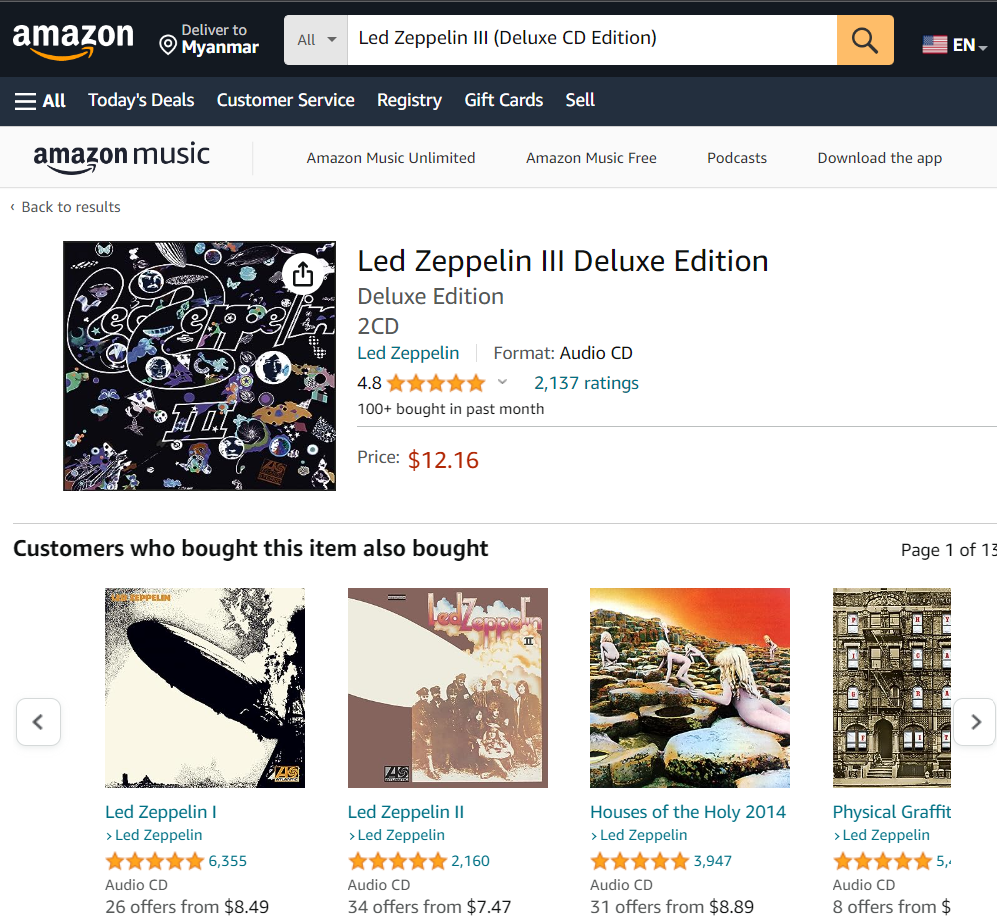

In [11]:
from IPython import display
display.Image("F:/UniPrj/Big Data Project/fpgrowth.png")

In [ ]:
Insights:

According to this frequent item associations analysis, we can used these analyzed data for targeted recommendations, 
bundling deals, email campaigns, and seasonal promotions to boost e-commerce sales effectively.
